# Assessment of the incident power density on spherical human head model

In [1]:
import itertools
import os
import time

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import pathpatch_2d_to_3d, Poly3DCollection
import numpy as np
import pandas as pd
from scipy.special import roots_legendre
from scipy.spatial import ConvexHull
import seaborn as sns
from tqdm.auto import tqdm

from dosipy.field import poynting
from dosipy.utils.dataloader import (load_antenna_el_properties,
                                     load_sphere_coords)
from dosipy.utils.derive import holoborodko
from dosipy.utils.integrate import elementwise_rectquad as equad
from dosipy.utils.viz import (fig_config, save_fig, set_axes_equal,
                              set_colorblind)

In [2]:
print(f'platform: {jax.lib.xla_bridge.get_backend().platform}')

platform: cpu


In [3]:
# jax.config.update("jax_enable_x64", True)

In [4]:
set_colorblind()
%config InlineBackend.figure_format = 'retina'

In [5]:
# utils

def cart2sph(x, y, z):
    """Return spherical given Cartesain coordinates."""
    r = jnp.sqrt(x ** 2 + y ** 2 + z ** 2)
    theta = jnp.arccos(z / r)
    phi = jnp.arctan2(y, x)
    return r, theta, phi


def sph2cart(r, theta, phi):
    """Return Cartesian given Spherical coordinates."""
    x = r * jnp.cos(phi) * jnp.sin(theta)
    y = r * jnp.sin(phi) * jnp.sin(theta)
    z = r * jnp.cos(theta)
    return x, y, z

## Current distribution along the antenna operating in mmWave freq. spectrum

In [6]:
# load pre-computed source data

f = 10e9  # operating frequency of the antenna
antenna_data = load_antenna_el_properties(f)
Is = antenna_data.ireal.to_numpy() + antenna_data.iimag.to_numpy() * 1j
Is = jnp.asarray(Is)
xs = antenna_data.x.to_numpy()
xs = jnp.asarray(xs)

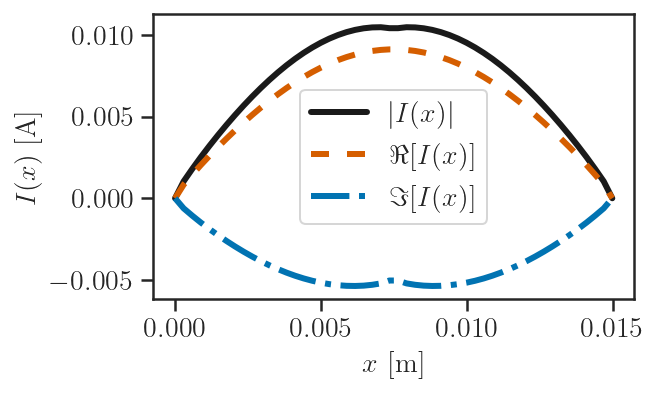

In [7]:
# visualize the complex spatial distribution of the current along the wire

fig_config(latex=True, text_size=14, scaler=1)
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(xs, jnp.abs(Is), 'k-', label=r'$|I(x)|$')
ax.plot(xs, Is.real, 'r--', label='$\\Re{[I(x)]}$')
ax.plot(xs, Is.imag, 'b-.', label='$\\Im{[I(x)]}$')
ax.set(xlabel=r'$x$ [m]', ylabel=r'$I(x)$ [A]')
ax.legend()
fig.tight_layout();

fname = os.path.join('figures', 'I_dist')
save_fig(fig, fname=fname)

## Spherical model of human head in close proximity to the antenna (f.s. conditions)

In [8]:
# load pre-computed model coordinates

r_c = load_sphere_coords(2312)  # spherical head model coordinates
d = -5 / 1000  # distance between the head model and the antenna
xs = xs - xs.max() / 2  # fix antenna position w.r.t. the target model position
ys = jnp.zeros_like(xs) + r_c['y'].min() + d  # y-coordinates of the antenna
zs = jnp.zeros_like(xs)  # z-coordinates of the antenna
dx = xs[1] - xs[0]  # finite difference
Is_x = holoborodko(Is, dx)  # spatial distribution of current derivative

In [9]:
# compute power density values at each sampled point of the model

S = r_c.apply(
    lambda row: poynting(row['x'], row['y'], row['z'], xs, ys, zs, f, Is, Is_x),
    axis=1, result_type='expand')
S.columns = ['Sx', 'Sy', 'Sz']
S_abs = S.apply(
    lambda row: jnp.sqrt(row['Sx'] ** 2 + row['Sy'] ** 2 + row['Sz'] ** 2),
    axis=1)
S.loc[:, 'S_abs'] = S_abs

# update dataframe with computed power density values
r_c_calc = pd.concat([r_c, S], axis=1)

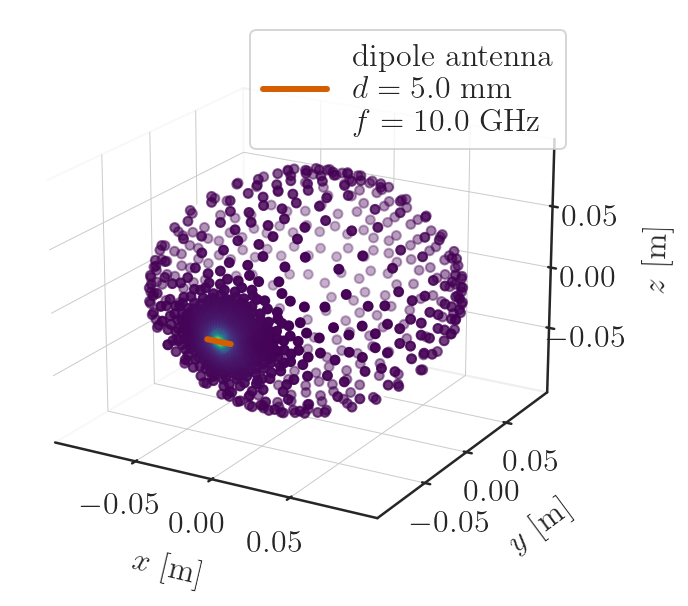

In [10]:
# visualize absolute values of the power density on the model's surface

hull = ConvexHull(r_c_calc[['x', 'y', 'z']].to_numpy())
triangle_coords = hull.points[hull.simplices]

fig_config(latex=True, text_size=16, scaler=1.5)
fig = plt.figure()
ax = plt.axes(projection ='3d')
ax.add_collection3d(Poly3DCollection(triangle_coords, color='white'))
ax.scatter(r_c_calc['x'], r_c_calc['y'], r_c_calc['z'],
           c=np.abs(r_c_calc['S_abs']), cmap='viridis')
ax.plot(xs, ys, zs, 'r-', zorder=4,
        label=(f'dipole antenna\n$d = {-d * 1000}$ mm\n$f = {f / 1e9}$ GHz'))
ax.set(xlabel='$x$ [m]', ylabel='$y$ [m]', zlabel='$z$ [m]',
       xticks=[-0.05, 0.0, 0.05],
       yticks=[-0.05, 0.0, 0.05],
       zticks=[-0.05, 0.0, 0.05],
       xlim3d=[-0.1, 0.1],
       ylim3d=[-0.1, 0.1],
       zlim3d=[-0.1, 0.1])
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.xaxis.labelpad = 12
ax.yaxis.labelpad = 12
ax.zaxis.labelpad = 12

ax.legend()
ax.view_init(20, -60)
ax = set_axes_equal(ax)
fig.tight_layout();

# fname = os.path.join('figures', 'PD_dist_3D')
# save_fig(fig, fname=fname)

In [11]:
# define the effective irradiated area for the computation of the incident power density

target_area = (2 / 100, 2 / 100)
A = target_area[0] * target_area[1]
target_area_origin = (-target_area[0]/2, -target_area[1]/2)

r_c_calc_ta = r_c_calc[
    (r_c_calc['y'] < 0) &
    (r_c_calc['x'] > target_area_origin[0]) &
    (r_c_calc['x'] < target_area_origin[0] * -1) &
    (r_c_calc['z'] > target_area_origin[1]) &
    (r_c_calc['z'] < target_area_origin[1] * -1)]
r_c_calc_ta.reset_index(drop=True, inplace=True)

xt = r_c_calc_ta['x'].to_numpy()
yt = r_c_calc_ta['y'].to_numpy()
zt = r_c_calc_ta['z'].to_numpy()

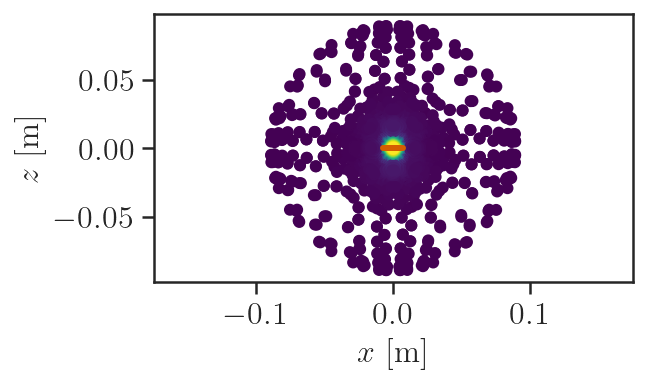

In [12]:
# visualize the absolute power density values on the head surface from the antenna point of view

fig_config(latex=True, text_size=16, scaler=1)
fig = plt.figure()
ax = fig.add_subplot()
ax.axis('equal')
cs = ax.scatter(r_c_calc['x'], r_c_calc['z'],
                c=np.abs(r_c_calc['S_abs']), cmap='viridis')
#cbar = fig.colorbar(cs)
#cbar.ax.set_ylabel('$\\vec{S}$ [W/m$^2$]')
ax.plot(xs, zs, 'r-')
ax.set_xlabel('$x$ [m]')
ax.set_ylabel('$z$ [m]')
fig.tight_layout();

# fname = os.path.join('figures', 'PD_dist_2D')
# save_fig(fig, fname=fname)

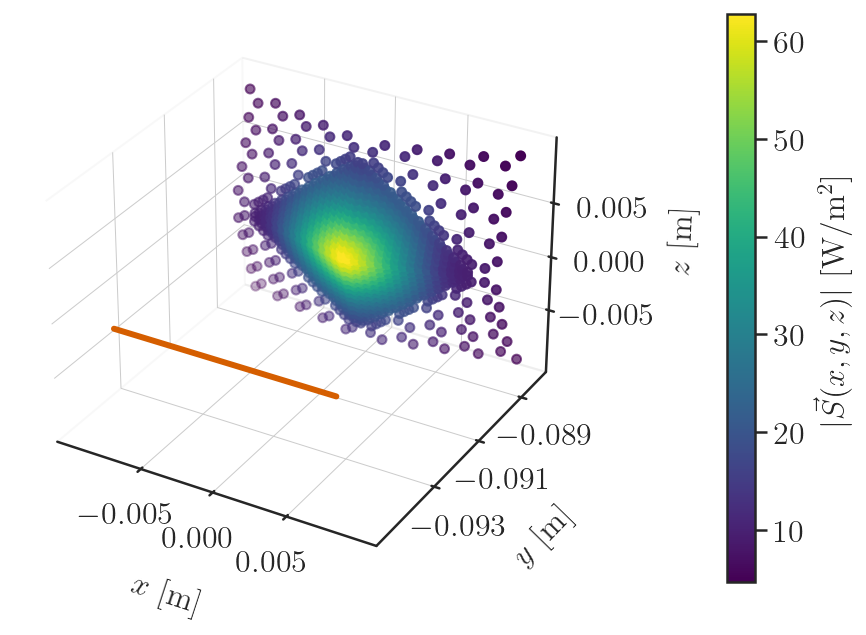

In [13]:
# visualize the absolute power density values on the effective irradiated area

fig_config(latex=True, text_size=16, scaler=1.5)
fig = plt.figure()
ax = plt.axes(projection ='3d')

cs = ax.scatter(xt, yt, zt, c=np.abs(r_c_calc_ta['S_abs']), cmap='viridis')
cbar = fig.colorbar(cs, pad=0.15)
cbar.ax.set_ylabel(r'$|\vec{S}(x, y, z)|$ [W/m$^2$]')
ax.plot(xs, ys, zs, linestyle='-', c='r', zorder=1)
ax.set(xlabel='$x$ [m]', ylabel='$y$ [m]', zlabel='$z$ [m]',
       xticks=[-0.005, 0.0, 0.005],
       yticks=[-0.093, -0.091, -0.089],
       zticks=[-0.005, 0.0, 0.005])
ax.tick_params(axis='z', which='major', pad=10)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.xaxis.labelpad = 15
ax.yaxis.labelpad = 15
ax.zaxis.labelpad = 20

fig.tight_layout();

# fname = os.path.join('figures', 'PD_dist_3D_zoomin')
# save_fig(fig, fname=fname)

In [14]:
# generate Gaussian points in spherical c.s. and convert to Cartesian c.s.
_, theta, phi = cart2sph(xt, yt, zt)
theta_a = theta.min()
theta_b = theta.max()
phi_a = phi.min()
phi_b = phi.max()
roots, weights = roots_legendre(20)
theta_points = 0.5 * (roots + 1.) * (theta_b - theta_a) + theta_a
theta_weights = 0.5 * weights * (theta_b - theta_a)
phi_points = 0.5 * (roots + 1.) * (phi_b - phi_a) + phi_a
phi_weights = 0.5 * weights * (phi_b - phi_a)

r = 0.09  # radius of the head model
phi_grid, theta_grid = jnp.meshgrid(phi_points, theta_points)
xt_spherical, yt_spherical, zt_spherical = sph2cart(r, theta_grid.ravel(), phi_grid.ravel())

In [15]:
# compute the power density on the surface of the skin

Sx, Sy, Sz = [], [], []
for _xt, _yt, _zt in zip(xt_spherical, yt_spherical, zt_spherical):
    _Sx, _Sy, _Sz = poynting(_xt, _yt, _zt, xs, ys, zs, f, Is, Is_x)
    Sx.append(_Sx)
    Sy.append(_Sy)
    Sz.append(_Sz)
Sx = jnp.asarray(Sx)
Sy = jnp.asarray(Sy)
Sz = jnp.asarray(Sz)

S = jnp.sqrt(Sx ** 2 + Sy ** 2 + Sz ** 2)

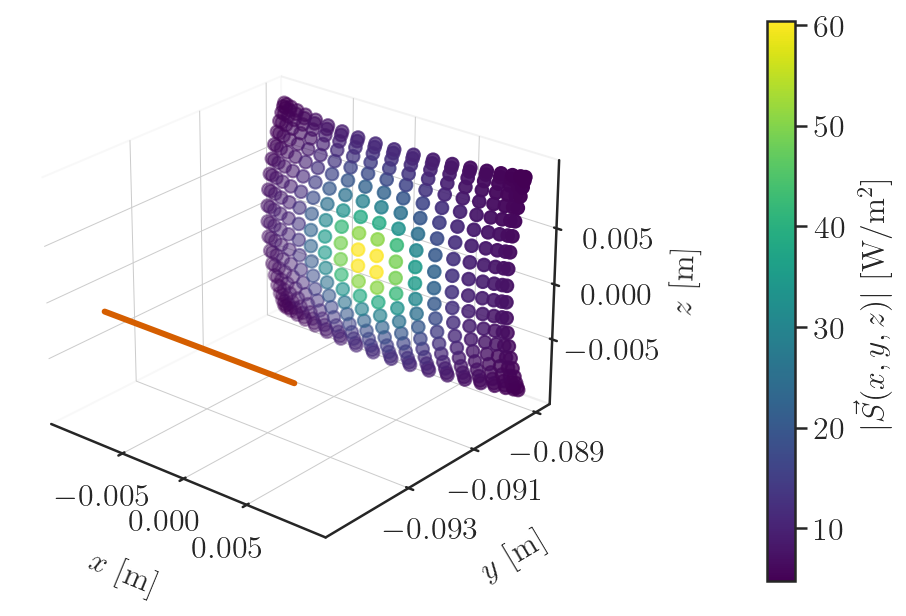

In [16]:
# visualize the power density on the surface of the skin inside the target area

fig_config(latex=True, text_size=16, scaler=1.5)
fig = plt.figure()
ax = plt.axes(projection ='3d')
cs = ax.scatter(xt_spherical, yt_spherical, zt_spherical, s=40,
                c=jnp.abs(S), cmap='viridis')
cbar = fig.colorbar(cs, pad=0.2)
cbar.ax.set_ylabel(r'$|\vec{S}(x, y, z)|$ [W/m$^2$]')
ax.plot(xs, ys, zs, linestyle='-', c='r')
ax.set(xlabel='$x$ [m]', ylabel='$y$ [m]', zlabel='$z$ [m]',
       xticks=[-0.005, 0.0, 0.005],
       yticks=[-0.093, -0.091, -0.089],
       zticks=[-0.005, 0.0, 0.005])
ax.tick_params(axis='z', which='major', pad=10)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.xaxis.labelpad = 15
ax.yaxis.labelpad = 15
ax.zaxis.labelpad = 17
ax.view_init(25, -50)
fig.tight_layout();

# fname = os.path.join('figures', 'PD_dist_3D_Gauss_mag')
# save_fig(fig, fname=fname)

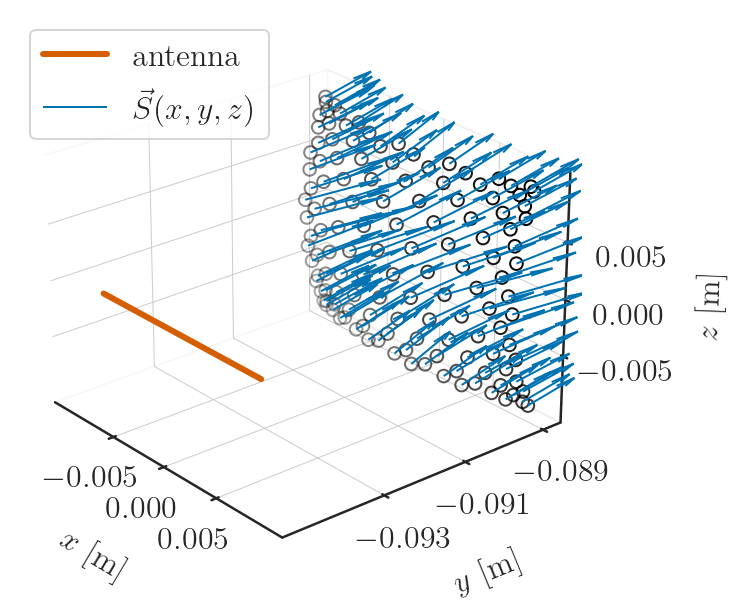

In [17]:
# visualize the EM power density vector field on the surface of the skin inside the target area

fig_config(latex=True, text_size=16, scaler=1.5)
fig = plt.figure()
ax = plt.axes(projection ='3d')
ax.scatter(xt_spherical[::3], yt_spherical[::3], zt_spherical[::3], s=40,
           ec='black', fc='None')
ax.plot(xs, ys, zs, linestyle='-', c='r', label='antenna')
q = ax.quiver(xt_spherical[::3], yt_spherical[::3], zt_spherical[::3],
              jnp.abs(Sx[::3]), jnp.abs(Sy[::3]), jnp.abs(Sz[::3]),
              linewidths=1, length=0.002, normalize=True, color='b',
              label='$\\vec{S}(x, y, z)$')
ax.set(xlabel='$x$ [m]', ylabel='$y$ [m]', zlabel='$z$ [m]',
       xticks=[-0.005, 0.0, 0.005],
       yticks=[-0.093, -0.091, -0.089],
       zticks=[-0.005, 0.0, 0.005])
ax.tick_params(axis='z', which='major', pad=10)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.xaxis.labelpad = 15
ax.yaxis.labelpad = 15
ax.zaxis.labelpad = 20
ax.view_init(25, -40)
ax.legend()
fig.tight_layout();

# fname = os.path.join('figures', 'PD_dist_3D_Gauss_vec')
# save_fig(fig, fname=fname)

In [18]:
# compute the incident power density

nx, ny, nz = [], [], []
poynting_mag = 0
A_spherical = 0
for _theta, _w_theta in zip(theta_points, theta_weights):
    for _phi, _w_phi in zip(phi_points, phi_weights):
        # normal vector components
        _nx = r ** 2 * jnp.cos(_phi) * jnp.sin(_theta) ** 2 
        _ny = r ** 2 * jnp.sin(_phi) * jnp.sin(_theta) ** 2
        _nz = r ** 2 * jnp.cos(_theta) * jnp.sin(_theta)
        nx.append(_nx)
        ny.append(_ny)
        nz.append(_nz)
        # power density vector field
        _xt, _yt, _zt = sph2cart(r, _theta, _phi)
        _Sx, _Sy, _Sz = poynting(_xt, _yt, _zt, xs, ys, zs, f, Is, Is_x)
        # dot product between power density and normal vector
        Fn = _Sx.real * _nx + _Sy.real * _ny + _Sz.real * _nz
        # incident power integration
        poynting_mag += Fn * _w_theta * _w_phi
        # surface area integration
        A_spherical += jnp.sin(_theta) * r ** 2 * _w_theta * _w_phi
Sab_spherical = poynting_mag / (2 * A_spherical)

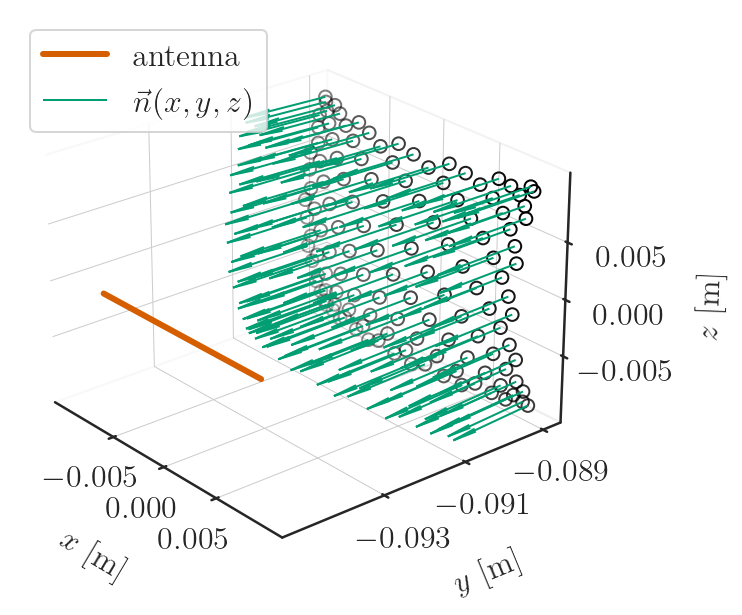

In [19]:
# visualize normal vectors to the surface of the skin inside the target area

fig_config(latex=True, text_size=16, scaler=1.5)
fig = plt.figure()
ax = plt.axes(projection ='3d')
ax.scatter(xt_spherical[::3], yt_spherical[::3], zt_spherical[::3], s=40,
           ec='black', fc='None')
ax.plot(xs, ys, zs, linestyle='-', c='r', label='antenna')
ax.quiver(xt_spherical[::3], yt_spherical[::3], zt_spherical[::3],
          nx[::3], ny[::3], nz[::3],
          linewidths=1, length=0.002, normalize=True, color='g',
          label='$\\vec{n}(x, y, z)$')
ax.set(xlabel='$x$ [m]', ylabel='$y$ [m]', zlabel='$z$ [m]',
       xticks=[-0.005, 0.0, 0.005],
       yticks=[-0.093, -0.091, -0.089],
       zticks=[-0.005, 0.0, 0.005])
ax.tick_params(axis='z', which='major', pad=10)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.xaxis.labelpad = 15
ax.yaxis.labelpad = 15
ax.zaxis.labelpad = 20
ax.view_init(25, -40)
ax.legend()
fig.tight_layout();

# fname = os.path.join('figures', 'normals_3D_Gauss_vec')
# save_fig(fig, fname=fname)

In [20]:
print(f'spherical surface, IPD = {Sab_spherical:.4f} W/m2')

spherical surface, IPD = 6.2062 W/m2


## Planar model of human head in close proximity to the antenna (f.s. conditions)

In [21]:
# generate coordinates for 3 different planar models

yt_planar_near = yt_spherical.min()
yt_planar_far = yt_spherical.max()
yt_planar_mid = (yt_planar_far + yt_planar_near) / 2

xt_planar = jnp.linspace(-target_area[0]/2, target_area[0]/2, 11) + xs[-1] / 2
zt_planar = jnp.linspace(-target_area[1]/2, target_area[1]/2, 11)

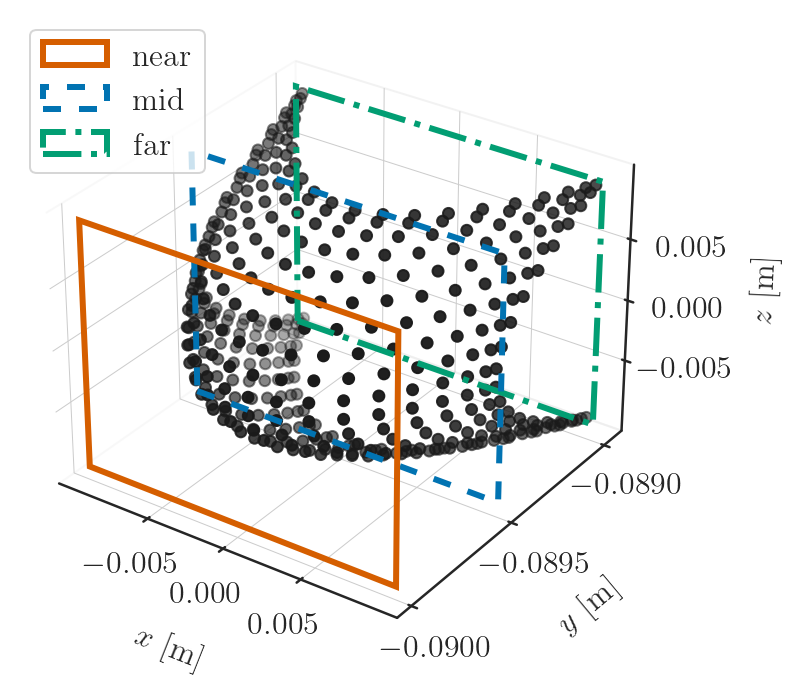

In [22]:
# visualize the power density on the surface of the skin inside the target area

fig_config(latex=True, scaler=2)
fig = plt.figure()
ax = plt.axes(projection ='3d')

ax.scatter(xt_spherical, yt_spherical, zt_spherical, c='k', s=30,)
sur_planar_near = Rectangle(target_area_origin, target_area[0], target_area[1],
                  ec='r', ls='-', fc='None', lw=3, label='near')
sur_planar_mid = Rectangle(target_area_origin, target_area[0], target_area[1],
                  ec='b', ls='--', fc='None', lw=3, label='mid')
sur_planar_far = Rectangle(target_area_origin, target_area[0], target_area[1],
                  ec='g', ls='-.', fc='None', lw=3, label='far')
ax.add_patch(sur_planar_near)
ax.add_patch(sur_planar_mid)
ax.add_patch(sur_planar_far)
pathpatch_2d_to_3d(sur_planar_near, z=yt_planar_near, zdir='y')
pathpatch_2d_to_3d(sur_planar_mid, z=yt_planar_mid, zdir='y')
pathpatch_2d_to_3d(sur_planar_far, z=yt_planar_far, zdir='y')

ax.set(xlabel='$x$ [m]', ylabel='$y$ [m]', zlabel='$z$ [m]',
       xticks=[-0.005, 0.0, 0.005],
       yticks=[round(yt_planar_near, 4),
               round(yt_planar_mid, 4),
               round(yt_planar_far, 4)],
       zticks=[-0.005, 0.0, 0.005])
ax.tick_params(axis='z', which='major', pad=10)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.xaxis.labelpad = 15
ax.yaxis.labelpad = 15
ax.zaxis.labelpad = 20
ax.view_init(30, -55)
ax.legend()
fig.tight_layout;

fname = os.path.join('figures', 'surfaces')
save_fig(fig, fname=fname)

In [23]:
# incident power density for planar model

def Sab_planar_fn(yt_planar):
    S = np.empty((xt_planar.size, zt_planar.size), dtype=np.complex64)
    for xi, _xt in enumerate(xt_planar):
        for zi, _zt in enumerate(zt_planar):
            _Sx, _Sy, _Sz = poynting(_xt, yt_planar, _zt, xs, ys, zs, f, Is, Is_x)
            S[xi, zi] = jnp.sqrt(_Sx ** 2 + _Sy ** 2 + _Sz ** 2)
    return 1 / (2 * A) * equad(xt_planar, zt_planar, S.real)


Sab_planar_near = Sab_planar_fn(yt_planar_near)
Sab_planar_mid = Sab_planar_fn(yt_planar_mid)
Sab_planar_far = Sab_planar_fn(yt_planar_far)

In [24]:
print(f'spherical surface of A = {A_spherical * 1e4:.2f} cm2, IPD = {Sab_spherical:.4f} W/m2')
print(f'near planar surface of A = {A * 1e4:.2f} cm2, IPD = {Sab_planar_near:.4f} W/m2')
print(f'mid planar surface of A = {A * 1e4:.2f} cm2, IPD = {Sab_planar_mid:.4f} W/m2')
print(f'far planar surface of A = {A * 1e4:.2f} cm2, IPD = {Sab_planar_far:.4f} W/m2')

spherical surface of A = 3.74 cm2, IPD = 6.2062 W/m2
near planar surface of A = 4.00 cm2, IPD = 6.4739 W/m2
mid planar surface of A = 4.00 cm2, IPD = 5.9901 W/m2
far planar surface of A = 4.00 cm2, IPD = 5.5545 W/m2


## Comparisson between planar and spherical models

In [26]:
ds = np.array([2.5, 5, 10, 15, 25, 45]) / -1000. # distance from the antenna
fs = np.array([3.5, 6., 10., 26., 30., 60., 80., 100.])  # frequencies in GHz
p = 11  # number of root points

In [27]:
def compute_IPD(f, d, p):
    assert f in [3.5, 6., 10., 26., 30., 60., 80., 100.]
    target_area = (2 / 100, 2 / 100)
    if f < 30:
        target_area = (2 / 100, 2 / 100)  # effective irradiated surface area, 4cm2
    else:
        target_area = (1 / 100, 1 / 100)  # effective irradiated surface area, 1cm2
    A = target_area[0] * target_area[1]  # area of the effective irradiated surface
    
    # target coordinates for curved model
    data = load_sphere_coords(2312)  # spherical head model coordinates
    target_area_origin = (-target_area[0]/2, -target_area[1]/2)
    data_target = data[  # effective irradiated skin surface
        (data['y'] < 0) &
        (data['x'] > target_area_origin[0]) &
        (data['x'] < target_area_origin[0] * -1) &
        (data['z'] > target_area_origin[1]) &
        (data['z'] < target_area_origin[1] * -1)]
    data_target.reset_index(drop=True, inplace=True)
    xt_spherical = data_target['x'].to_numpy()
    yt_spherical = data_target['y'].to_numpy()
    zt_spherical = data_target['z'].to_numpy()
    
    # source data
    f = f * 1e9
    antenna_data = load_antenna_el_properties(f)
    Is = antenna_data.ireal.to_numpy() + antenna_data.iimag.to_numpy() * 1j
    Is = jnp.asarray(Is)
    xs = antenna_data.x.to_numpy()
    xs = jnp.asarray(xs)
    xs = xs - xs.max() / 2
    ys = jnp.zeros_like(xs) + data_target['y'].min() + d
    zs = jnp.zeros_like(xs)
    dx = xs[1] - xs[0]
    Is_x = holoborodko(Is, dx)
    
    # target coordinates for planar model
    xt_planar = jnp.linspace(-target_area[0] / 2, target_area[0] / 2, p) + xs[-1] / 2
    yt_planar_near = yt_spherical.min()
    yt_planar_far = yt_spherical.max()
    yt_planar_mid = (yt_planar_far + yt_planar_near) / 2
    zt_planar = jnp.linspace(-target_area[1] / 2, target_area[1] / 2, p)
        
    # incident power density for planar model
    S_planar_near = np.empty((xt_planar.size, zt_planar.size), dtype=np.complex64)
    S_planar_far = np.empty_like(S_planar_near)
    S_planar_mid = np.empty_like(S_planar_near)
    for xi, _xt in enumerate(xt_planar):
        for zi, _zt in enumerate(zt_planar):
            _Sx, _Sy, _Sz = poynting(_xt, yt_planar_near, _zt, xs, ys, zs, f, Is, Is_x)
            S_planar_near[xi, zi] = jnp.sqrt(_Sx ** 2 + _Sy ** 2 + _Sz ** 2)
            _Sx, _Sy, _Sz = poynting(_xt, yt_planar_far, _zt, xs, ys, zs, f, Is, Is_x)
            S_planar_far[xi, zi] = jnp.sqrt(_Sx ** 2 + _Sy ** 2 + _Sz ** 2)
            _Sx, _Sy, _Sz = poynting(_xt, yt_planar_mid, _zt, xs, ys, zs, f, Is, Is_x)
            S_planar_mid[xi, zi] = jnp.sqrt(_Sx ** 2 + _Sy ** 2 + _Sz ** 2)
    Sab_planar_near = 1 / (2 * A) * equad(xt_planar, zt_planar, S_planar_near.real)
    Sab_planar_far = 1 / (2 * A) * equad(xt_planar, zt_planar, S_planar_far.real)
    Sab_planar_mid = 1 / (2 * A) * equad(xt_planar, zt_planar, S_planar_mid.real)
    
    
    # generate Gaussian points in spherical c.s. and convert to Cartesian c.s.
    _, theta, phi = cart2sph(xt_spherical, yt_spherical, zt_spherical)
    theta_a = theta.min()
    theta_b = theta.max()
    phi_a = phi.min()
    phi_b = phi.max()
    theta_points, theta_weights = roots_legendre(p)
    phi_points, phi_weights = roots_legendre(p)
    theta_points = 0.5 * (theta_points + 1.) * (theta_b - theta_a) + theta_a
    theta_weights = 0.5 * theta_weights * (theta_b - theta_a)
    phi_points = 0.5 * (phi_points + 1.) * (phi_b - phi_a) + phi_a
    phi_weights = 0.5 * phi_weights * (phi_b - phi_a)
    r = 0.09
    
    # incident power density for curved model
    poynting_mag = 0
    A_spherical = 0
    for _theta, _w_theta in zip(theta_points, theta_weights):
        for _phi, _w_phi in zip(phi_points, phi_weights):
            # normal vector components
            nx = r ** 2 * jnp.cos(_phi) * jnp.sin(_theta) ** 2 
            ny = r ** 2 * jnp.sin(_phi) * jnp.sin(_theta) ** 2
            nz = r ** 2 * jnp.cos(_theta) * jnp.sin(_theta)
            # power density vector field
            _xt, _yt, _zt = sph2cart(r, _theta, _phi)
            _Sx, _Sy, _Sz = poynting(_xt, _yt, _zt, xs, ys, zs, f, Is, Is_x)
            # dot product between power density and normal vector
            Fn = _Sx.real * nx + _Sy.real * ny + _Sz.real * nz
            # Gaussian quadrature
            poynting_mag += Fn * _w_theta * _w_phi
            A_spherical += jnp.sin(_theta) * r ** 2 * _w_theta * _w_phi
    Sab_spherical = poynting_mag / (2 * A_spherical)
    return Sab_planar_near, Sab_planar_far, Sab_planar_mid, Sab_spherical

In [28]:
# compute IPDs for 3 different kinds of planar models and spherical model of human head

p = 11
dsfs = list(itertools.product(ds, fs))
n_IPD_per_d = fs.size
res = np.zeros((ds.size * n_IPD_per_d, 7))
i = 0
for d, f in tqdm(dsfs):
    Sab_planar_near, Sab_planar_far, Sab_planar_mid, Sab_spherical = compute_IPD(f, d, p)
    res[i, :] = [f, d, p, Sab_planar_near, Sab_planar_far, Sab_planar_mid, Sab_spherical]
    i += 1
    
# np.save(os.path.join('analysis', 'output-main-2022-01-15', 'ipd_sim_output.npy'), res)

  0%|          | 0/48 [00:00<?, ?it/s]

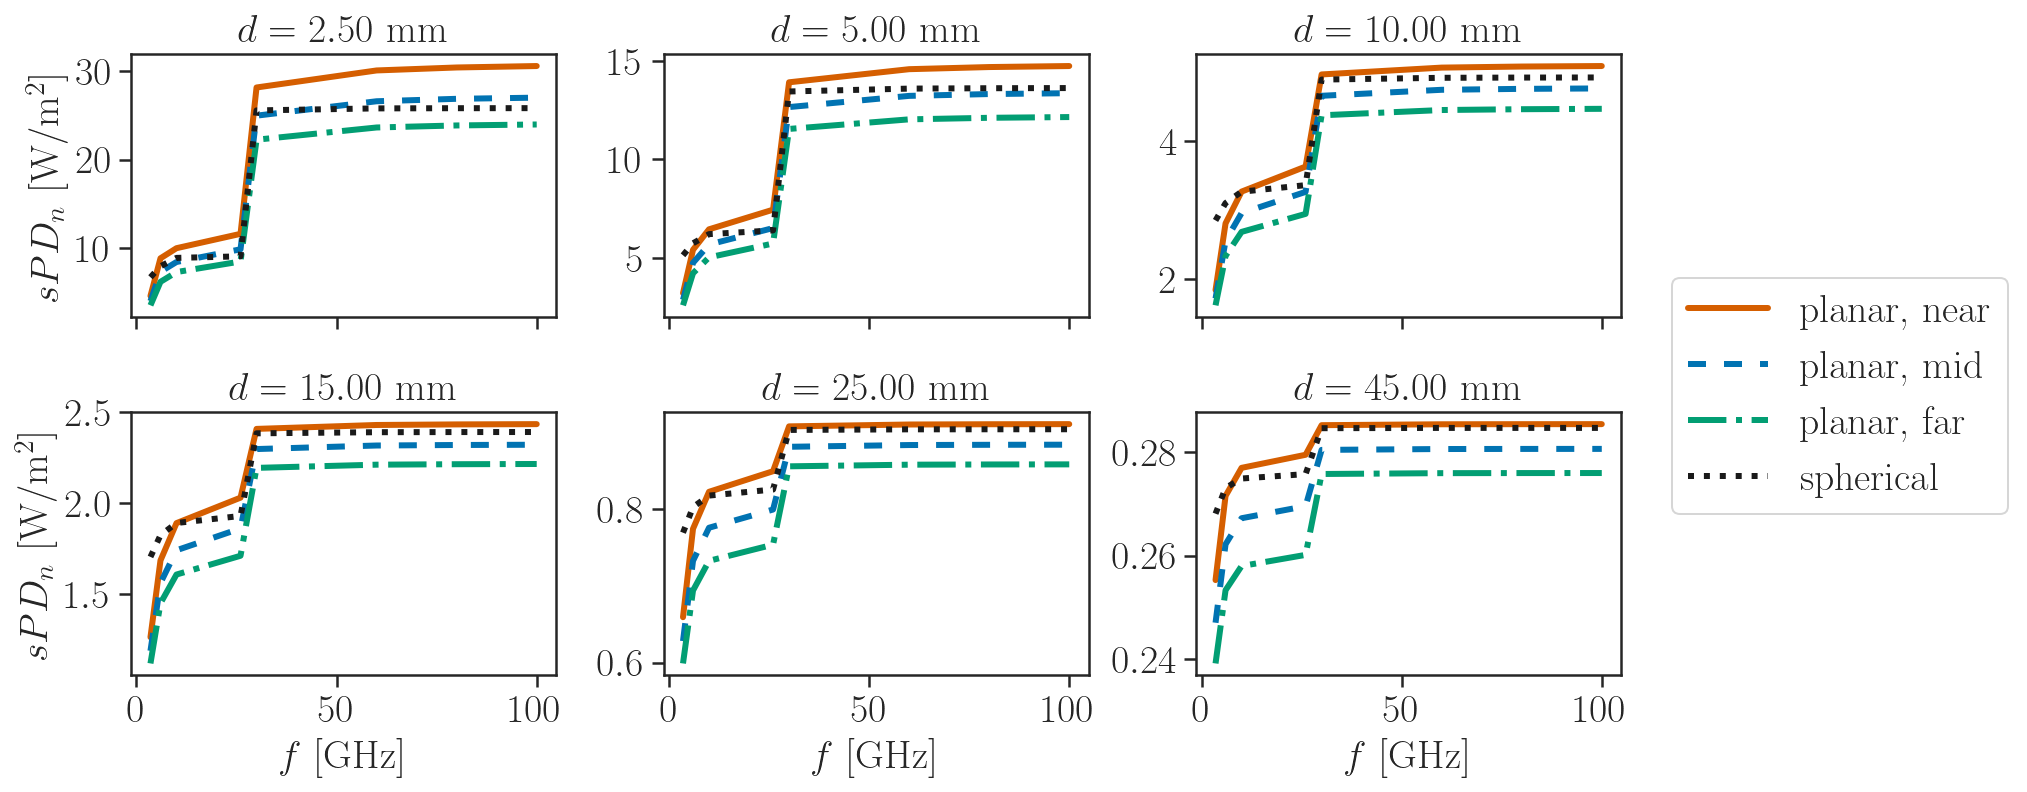

In [30]:
# visualize IPDs for 3 different kinds of planar models and spherical model of human head
# w.r.t. frequency and depending on the position to the antenna

n_rows = 2
n_cols = 3
fig_config(latex=True, text_size=20, nrows=n_rows, ncols=n_cols)
fig = plt.figure()
axs = fig.subplots(n_rows, n_cols, sharex=True)
i_start = 0
i_end = n_IPD_per_d
d_idx = 0
for row in range(n_rows):
    for col in range(n_cols):
        axs[row, col].plot(fs, res[i_start:i_end, 3], 'r-', label='planar, near')
        axs[row, col].plot(fs, res[i_start:i_end, 5], 'b--', label='planar, mid')
        axs[row, col].plot(fs, res[i_start:i_end, 4], 'g-.', label='planar, far')
        axs[row, col].plot(fs, res[i_start:i_end, 6], 'k:', label='spherical')
        if col == 0:
            axs[row, col].set(ylabel='$sPD_{n}$ [W/m$^2$]')
        if row == 1:
            axs[row, col].set(xlabel='$f$ [GHz]')
        axs[row, col].set(title=f'$d = {np.abs(ds[d_idx]) * 1e3:.2f}$ mm')
        i_start = i_end
        i_end += n_IPD_per_d
        d_idx += 1
handles, labels = plt.gca().get_legend_handles_labels()
fig.legend(handles, labels, loc='center right')
fig.tight_layout()
fig.subplots_adjust(right=0.8);

fname = os.path.join('figures', 'IPD_sim')
save_fig(fig, fname=fname)

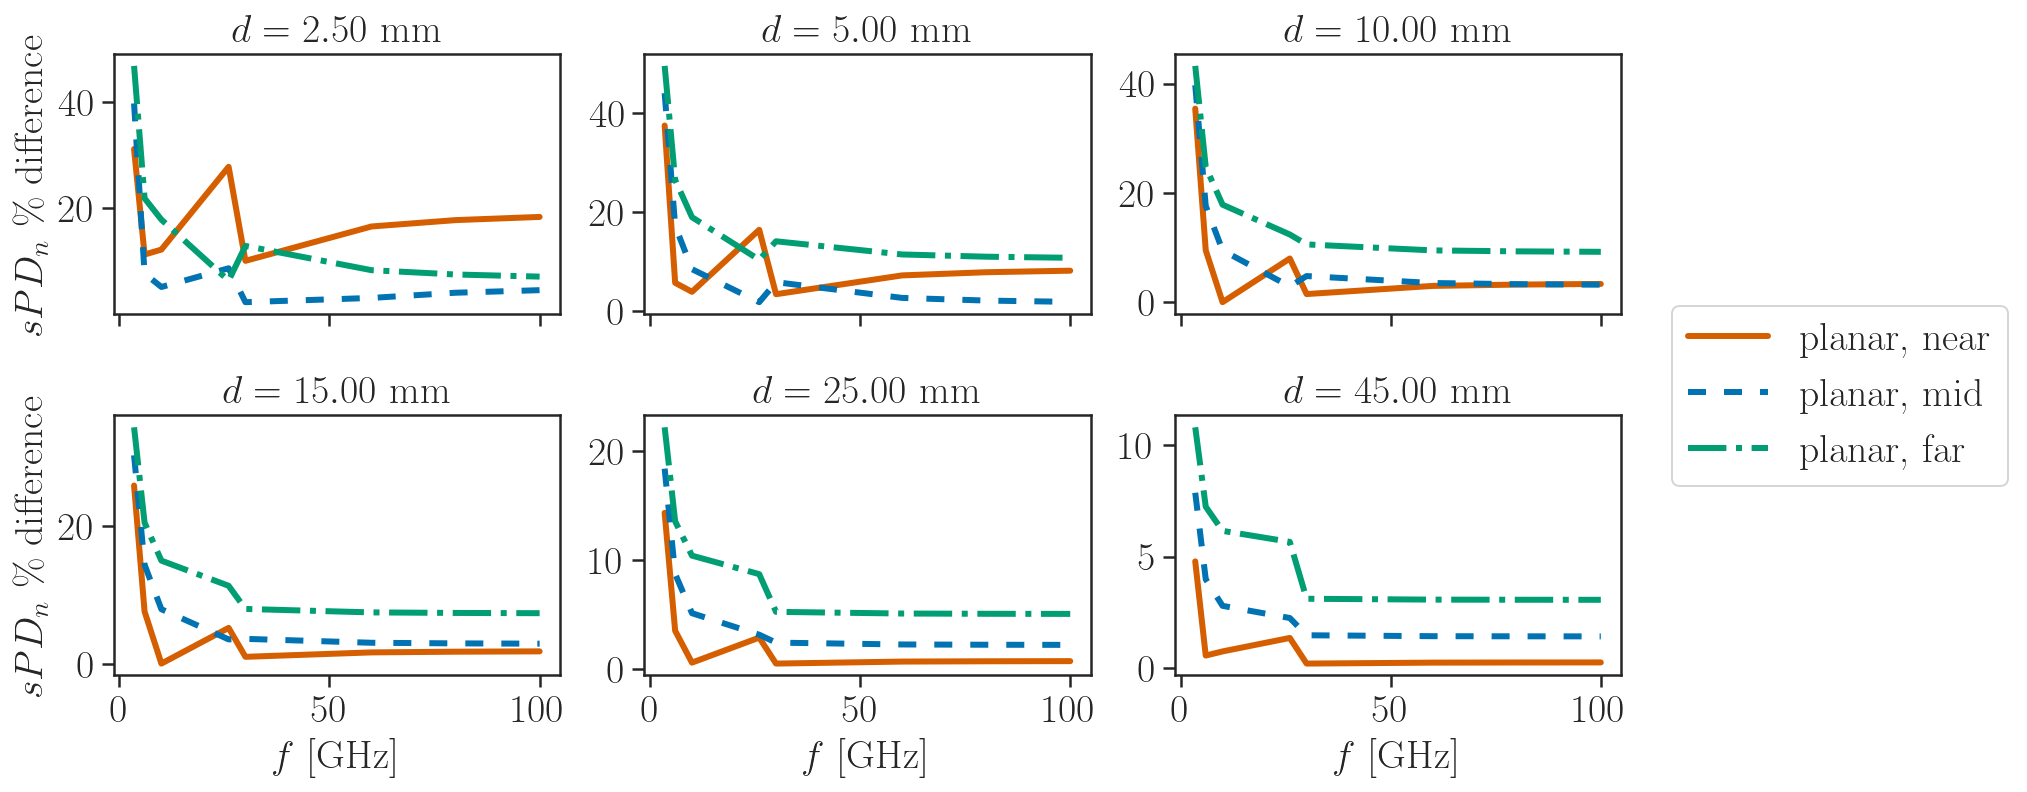

In [32]:
# visualize the absolute percentage difference between planar models and the spherical model

fig_config(latex=True, text_size=20, nrows=n_rows, ncols=n_cols)
fig = plt.figure()
axs = fig.subplots(n_rows, n_cols, sharex=True)
i_start = 0
i_end = n_IPD_per_d
d_idx = 0
for row in range(n_rows):
    for col in range(n_cols):
        abs_diff_near = jnp.abs((res[i_start:i_end, 3] - res[i_start:i_end, 6]) / res[i_start:i_end, 6])
        abs_diff_mid = jnp.abs((res[i_start:i_end, 5] - res[i_start:i_end, 6]) / res[i_start:i_end, 6])
        abs_diff_far = jnp.abs((res[i_start:i_end, 4] - res[i_start:i_end, 6]) / res[i_start:i_end, 6])
        axs[row, col].plot(fs, abs_diff_near * 100, 'r-', label='planar, near')
        axs[row, col].plot(fs, abs_diff_mid * 100, 'b--', label='planar, mid')
        axs[row, col].plot(fs, abs_diff_far * 100, 'g-.', label='planar, far')
        if col == 0:
            axs[row, col].set(ylabel='$sPD_{n}$ \% difference')
        if row == 1:
            axs[row, col].set(xlabel='$f$ [GHz]')
        axs[row, col].set(title=f'$d = {np.abs(ds[d_idx]) * 1e3:.2f}$ mm')
        i_start = i_end
        i_end += n_IPD_per_d
        d_idx += 1
handles, labels = plt.gca().get_legend_handles_labels()
fig.legend(handles, labels, loc='center right')
fig.tight_layout()
fig.subplots_adjust(right=0.8);

fname = os.path.join('figures', 'IPD_abs_diff')
save_fig(fig, fname=fname)